In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import accuracy_score


sns.set_style('darkgrid')
%matplotlib inline

/home/queimadas/.conda/envs/py3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class_names = ['queimada','não queimada']
colunas_stats = ['ndvi', 'nbrl', 'dif_ndvi', 'dif_dnbrl', 'medianb2', 'medianb3', 'medianb4', 'medianb5', 'medianb6', 'medianb7']

In [3]:
def get_melhores_colunas(df_rank):
    label_grupo_bom = df_rank[df_rank[1]==df_rank[1].max()].labels.values[0]
    melhores_colunas = df_rank[df_rank['labels']==label_grupo_bom][0]
    cols = melhores_colunas.values.tolist()
    return cols
def get_rank(df_conhecimento):
    # Criando classificador RF
    rf_clas = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=5, random_state=0, max_depth=3, min_samples_split=5)
    rf_clas.fit(df_conhecimento[colunas_stats], df_conhecimento.verifica)
    
    # Criando rank colunas
    df_rank = pd.DataFrame(sorted(list(zip(colunas_stats,rf_clas.feature_importances_)), key=lambda x: x[1], reverse=True))
    
    # Divide colunas em 2 grupos
    dados = df_rank[[1]].values
    kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, n_jobs=8)
    kmeans = kmeans.fit(dados)
    labels = kmeans.predict(dados)
    df_rank['labels'] = labels
    
    return df_rank

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
# Configura Modelo e teste com 70%-30%
df = pd.read_csv('conhecimento_filtrado.csv')

df1 = df[df.verifica==1].copy().reset_index(drop=True)
df3_full = df[df.verifica==3].copy().reset_index(drop=True)

ids_3 = np.random.choice(df3_full.id, len(df1), replace=False)
df3 = df[df.id.isin(ids_3)].copy().reset_index(drop=True)

df_conhecimento = pd.concat([df1, df3])
print(df_conhecimento.shape)

# Gera amostra para teste
parte_30 = int((len(df_conhecimento)/100)*30)
ids_30 = np.random.choice(df_conhecimento.id, parte_30, replace=False)
teste_original = df_conhecimento[df_conhecimento.id.isin(ids_30)].copy().reset_index(drop=True)
teste = teste_original.copy()
teste['verifica'] = 0
print(len(teste_original))

# Modelo
modelo = df_conhecimento[~df_conhecimento.id.isin(ids_30)].copy()
print(len(modelo))

(25786, 13)
7735
18051


In [5]:
def classifica(modelo, teste):
    print('Criando classificador RF')
    rf_clas = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=5, random_state=0, max_depth=3, min_samples_split=5)
    rf_clas.fit(modelo[colunas_stats], modelo.verifica)
    
    df_rank = get_rank(modelo)
    melhores_colunas = get_melhores_colunas(df_rank)
    
    print('RF - Classifica dado usando as melhores colunas')
    rf_clas = RandomForestClassifier(n_jobs=8, n_estimators=100, max_features=len(melhores_colunas), random_state=0, max_depth=3, min_samples_split=5)
    rf_clas.fit(modelo[melhores_colunas], modelo.verifica)
    teste['rf'] = rf_clas.predict(teste[melhores_colunas])
    teste['rf_1'] = rf_clas.predict_proba(teste[melhores_colunas])[:, 0]
    
    print('Classificando com NN')
    nn_clas = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.00010, max_iter=200)
    nn_clas.fit(modelo[melhores_colunas], modelo.verifica)
    teste['nn'] = nn_clas.predict(teste[melhores_colunas])
    teste['nn_1'] = nn_clas.predict_proba(teste[melhores_colunas])[:, 0]

    print('Cria avaliacao usando (RF+NN)/2 - Arredondado para 3 casas decimais')
    teste['avaliacao'] = (teste["rf_1"] + teste["nn_1"]) / 2
    teste['avaliacao'] = teste['avaliacao'].apply(lambda x: round(x, 4))
    
    teste['classificacao'] = teste.avaliacao.apply(lambda x: 1 if x > 0.9 else 3)
    teste['classificacao'].value_counts()
    
    return teste.sort_values('id').reset_index(drop=True)

In [6]:
def mostra_resultado(y_pred, y_true):
    cnf_matrix = confusion_matrix(y_true.verifica, y_pred.classificacao)
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Quantitativo')

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Porcentagem')

    plt.show()
    total_acertos = accuracy_score(y_true.verifica, y_pred.classificacao, normalize=False)
    porcentagem_acertos = int(accuracy_score(y_true.verifica, y_pred.classificacao)*100)
    print('Acertos: %s/%s (%s%%)' % (total_acertos, len(teste), porcentagem_acertos) )

In [7]:
y_pred = classifica(modelo, teste)
y_true = teste_original.sort_values('id').reset_index(drop=True)

Criando classificador RF
RF - Classifica dado usando as melhores colunas
Classificando com NN
Cria avaliacao usando (RF+NN)/2 - Arredondado para 3 casas decimais


Confusion matrix, without normalization
[[2688 1121]
 [  41 3885]]
Normalized confusion matrix
[[0.70569703 0.29430297]
 [0.0104432  0.9895568 ]]


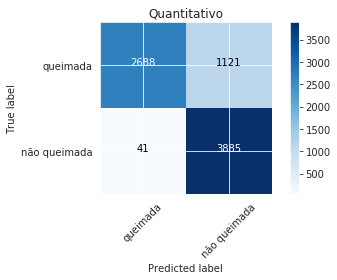

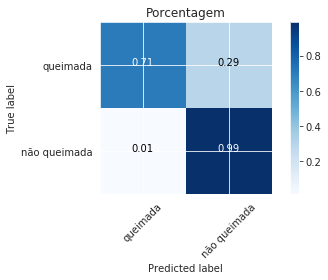

Acertos: 6573/7735 (84%)


In [8]:
mostra_resultado(y_pred, y_true)